<a href="https://colab.research.google.com/github/shariqfarhan/Explore/blob/master/S7_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import cv2
import torchvision
import torch
import torchvision.transforms as transforms

# Albumentations for augmentations

import albumentations as A
from albumentations.pytorch import ToTensorV2

# cv2.setNumThreads(0)
# cv2.ocl.setUseOpenCL(False)


class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
      super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, label


train_transforms = A.Compose(
    [
      # A.RandomCrop(width=16, height=16),
      A.HorizontalFlip(p=0.5),
      A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.5, 0.5, 0.5), mask_fill_value = None),
      A.ShiftScaleRotate(),
      # A.RandomBrightnessContrast(p=0.2),
      A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      ToTensorV2(),
    ],
    p=1.0,
)

test_transforms = A.Compose([
    A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      ToTensorV2(),
], p=1.0,
)


class args:
    def __init__(self, device="cpu", use_cuda=False) -> None:
        self.batch_size = 64
        self.device = device
        self.use_cuda = use_cuda
        self.kwargs = {"num_workers": 1, "pin_memory": True} if self.use_cuda else {}

trainset = Cifar10SearchDataset(
    root="./data", train=True, download=True, transform=train_transforms
)


trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=args().batch_size, shuffle=True, **args().kwargs
)

testset = Cifar10SearchDataset(
    root="./data", train=False, download=True, transform=test_transforms
)


testloader = torch.utils.data.DataLoader(
    testset, batch_size=args().batch_size, shuffle=True, **args().kwargs
)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F
dropout_value = 0.0

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock_0 = nn.Sequential(
                       nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),dilation=1,stride=1,padding=1,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(16),
                       nn.Dropout(dropout_value), # Input - 32x32x3 | Output - 32X32X16 | RF=3

                       nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),dilation=1,stride=1,padding=1,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(32),
                       nn.Dropout(dropout_value), # Input - 32X32X16 | Output - 32X32x32 |RF=5

                       nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),dilation=1,stride=1,padding=1,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(32),
                       nn.Dropout(dropout_value), # Input - 32X32X32 | Output - 32X32X64 |RF= 7

                       nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),dilation=1,stride=1,padding=1,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(32),
                       nn.Dropout(dropout_value), # Input - 32X32X64 | Output - 32X32X64 |RF= 9
                      )
        
        # depthwise seperable Convolution 1
        self.convblock_1 = nn.Sequential(
        
                       nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=(2,2),dilation=1,padding=1,bias=False,),# maxpool added after RF >11
                       nn.ReLU(),
                       nn.BatchNorm2d(64),
                       nn.Dropout(dropout_value), # Input - 32X32X64 | Output - 16X16X64 |RF=11

                       nn.Conv2d(in_channels=64,out_channels=64,groups=64,kernel_size=(3,3),stride=(1,1),dilation=1,padding=1,bias=False,),
                       # Input - 16X16X64 | Output - 16X16X64 | RF=15
                       nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(1,1),stride=(1,1),padding=0,bias=False,),
                       # Input - 16X16X64 | Output - 16X16X64 | RF=15
                       nn.ReLU(),
                       nn.BatchNorm2d(128), 
                       nn.Dropout(dropout_value), # 16X16X64 | RF=21                                       
                       # pointwise   

                       nn.Conv2d(in_channels=128,out_channels=128,groups=128,kernel_size=(3,3),dilation=1,stride=(1,1),padding=1,bias=False,),
                       # Input - 16X16X64 | Output - 16X16X64 | RF=29
                       nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(1,1),padding=0,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(64),   
                       nn.Dropout(dropout_value), 
                       # Input - 16X16X64 | Output - 16X16X32 | RF=29
                       
                      #nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=(1,1),dilation=2,padding=1,bias=False,),
                      # #  nn.Conv2d(in_channels=64,out_channels=64,groups=64,kernel_size=(3,3),stride=(1,1),padding=1,bias=False,),
                      # #  nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(1,1),padding=0,bias=False,),
                      #  nn.ReLU(),
                      #  nn.BatchNorm2d(64),   
                      #  nn.Dropout(dropout_value) , # 16X16X64 | RF=29                                                         
                       )
        # depthwise seperable Convolution 2
        self.convblock_2 = nn.Sequential(
        
                       nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(3,3),stride=(2,2),dilation=1,padding=1,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(32),   
                       nn.Dropout(dropout_value), 
                      # # Input - 16X16X32 | Output - 8X8X32 | RF=37

                       nn.Conv2d(in_channels=32,out_channels=32,groups=32,kernel_size=(3,3),stride=(1,1),padding=1,bias=False,),
                       # # Input - 8X8X32 | Output - 8X8X32 | RF=45
                       nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(1,1),stride=(1,1),padding=0,bias=False,),
                       # # Input - 8X8X32 | Output - 8X8X64 | RF=45
                       nn.ReLU(),
                       nn.BatchNorm2d(64),  
                       nn.Dropout(dropout_value),
                      # pointwise   

                       nn.Conv2d(in_channels=64,out_channels=64,groups=64,kernel_size=(3,3),stride=(1,1),padding=1,bias=False,),
                       # # Input - 8X8X64 | Output - 8X8X128 | RF=53
                       nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(1,1),stride=(1,1),padding=0,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(64),  # pointwise 
                       nn.Dropout(dropout_value) 
                       # # Input - 8X8X64 | Output - 8X8X64 | RF=53

                      )
        # depthwise seperable Convolution 2
        self.convblock_3 = nn.Sequential(
        
                       #Maxpooling
                       nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),dilation=1,stride=(2,2),padding=1,bias=False),
                       nn.ReLU(),
                       nn.BatchNorm2d(64),  
                       nn.Dropout(dropout_value),
                      # # Input - 8X8X64 | Output - 4X4X64 | RF=69

                       nn.Conv2d(in_channels=64,out_channels=128,groups=64,kernel_size=(3,3),stride=(1,1),padding=1,bias=False,),
                       # # Input - 4X4X64 | Output - 4X4X128 | RF=85
                       nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(1,1),stride=(1,1),padding=0,bias=False,),
                       nn.ReLU(),
                       nn.BatchNorm2d(64),
                       nn.Dropout(dropout_value),
                      #  # Input - 4X4X128 | Output - 4X4X64 | RF=85
                     
                       nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(3,3),dilation=2,stride=(1,1),padding=2,bias=False),
                       nn.ReLU(),
                       nn.BatchNorm2d(32),  
                       nn.Dropout(dropout_value),  
                       #  # Input - 4X4X128 | Output - 4X4X64 | RF=117

                       nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
                       # Input - 4X4X32 | Output - 4X4X10 | RF=117

                       )
        # 4X4X10 | RF=121
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
        self.fc = nn.Linear(in_features = 10, out_features = 10)

        # Input - 4X4X64 | Output - 1X1X64 
        # self.fc1 = nn.Linear(128,10)
        # self.fc2 = nn.Linear(64,10)

    
    def forward(self, x):
      
      x = self.convblock_0(x)
      x = self.convblock_1(x)
      x = self.convblock_2(x)
      x = self.convblock_3(x)
      x = self.gap(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)
      # x = self.fc1(x)
      # x = self.fc2(x)     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=1)

net = Net()

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0

In [4]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
incorr_X = []
incorr_y = []
incorr_argmax = []

def train(model, device, train_loader, optimizer, epoch, l1_penalty = True, lambda_l1 = 1e-5):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    if l1_penalty:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1

    train_losses.append(loss)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # The below code is added to identify misclassified images

            for idx, i in enumerate(output):
              if torch.argmax(i) == target[idx]:
                correct += 0 
                # To avoid double counting we don't add 1 here. If the above line of code ``` correct += pred.eq(target.view_as(pred)).sum().item() ```
                # wasn't there, we would add 1 here
              else:
                incorr_X.append(data)
                incorr_y.append(target)
                incorr_argmax.append(torch.argmax(i))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

EPOCH: 0


Loss=1.6539841890335083 Batch_id=781 Accuracy=34.78: 100%|██████████| 782/782 [00:21<00:00, 35.72it/s]



Test set: Average loss: 1.3916, Accuracy: 4910/10000 (49.10%)

EPOCH: 1


Loss=1.3953696489334106 Batch_id=781 Accuracy=47.74: 100%|██████████| 782/782 [00:20<00:00, 37.70it/s]



Test set: Average loss: 1.1406, Accuracy: 5883/10000 (58.83%)

EPOCH: 2


Loss=1.3590184450149536 Batch_id=781 Accuracy=53.97: 100%|██████████| 782/782 [00:20<00:00, 37.64it/s]



Test set: Average loss: 1.0282, Accuracy: 6324/10000 (63.24%)

EPOCH: 3


Loss=1.4220689535140991 Batch_id=781 Accuracy=57.64: 100%|██████████| 782/782 [00:20<00:00, 37.26it/s]



Test set: Average loss: 0.9438, Accuracy: 6622/10000 (66.22%)

EPOCH: 4


Loss=1.167194128036499 Batch_id=781 Accuracy=60.37: 100%|██████████| 782/782 [00:20<00:00, 37.45it/s]



Test set: Average loss: 0.8726, Accuracy: 6935/10000 (69.35%)

EPOCH: 5


Loss=0.6591940522193909 Batch_id=781 Accuracy=62.16: 100%|██████████| 782/782 [00:20<00:00, 37.71it/s]



Test set: Average loss: 0.7885, Accuracy: 7244/10000 (72.44%)

EPOCH: 6


Loss=1.0138815641403198 Batch_id=781 Accuracy=64.57: 100%|██████████| 782/782 [00:20<00:00, 37.53it/s]



Test set: Average loss: 0.7959, Accuracy: 7235/10000 (72.35%)

EPOCH: 7


Loss=1.331690788269043 Batch_id=781 Accuracy=65.32: 100%|██████████| 782/782 [00:21<00:00, 37.20it/s]



Test set: Average loss: 0.7649, Accuracy: 7300/10000 (73.00%)

EPOCH: 8


Loss=1.1082392930984497 Batch_id=781 Accuracy=66.93: 100%|██████████| 782/782 [00:21<00:00, 36.60it/s]



Test set: Average loss: 0.6931, Accuracy: 7577/10000 (75.77%)

EPOCH: 9


Loss=1.5621273517608643 Batch_id=781 Accuracy=67.51: 100%|██████████| 782/782 [00:20<00:00, 37.24it/s]



Test set: Average loss: 0.6895, Accuracy: 7576/10000 (75.76%)

EPOCH: 10


Loss=1.2854598760604858 Batch_id=781 Accuracy=68.55: 100%|██████████| 782/782 [00:21<00:00, 36.74it/s]



Test set: Average loss: 0.6529, Accuracy: 7736/10000 (77.36%)

EPOCH: 11


Loss=0.8199167251586914 Batch_id=781 Accuracy=69.40: 100%|██████████| 782/782 [00:21<00:00, 36.93it/s]



Test set: Average loss: 0.6416, Accuracy: 7785/10000 (77.85%)

EPOCH: 12


Loss=0.9428573846817017 Batch_id=781 Accuracy=69.96: 100%|██████████| 782/782 [00:20<00:00, 37.33it/s]



Test set: Average loss: 0.6304, Accuracy: 7829/10000 (78.29%)

EPOCH: 13


Loss=1.031165361404419 Batch_id=781 Accuracy=70.49: 100%|██████████| 782/782 [00:20<00:00, 37.33it/s]



Test set: Average loss: 0.6117, Accuracy: 7891/10000 (78.91%)

EPOCH: 14


Loss=1.174709439277649 Batch_id=781 Accuracy=71.37: 100%|██████████| 782/782 [00:21<00:00, 37.07it/s]



Test set: Average loss: 0.6140, Accuracy: 7859/10000 (78.59%)

EPOCH: 15


Loss=0.8991893529891968 Batch_id=781 Accuracy=71.94: 100%|██████████| 782/782 [00:21<00:00, 36.93it/s]



Test set: Average loss: 0.5737, Accuracy: 8070/10000 (80.70%)

EPOCH: 16


Loss=0.7198785543441772 Batch_id=781 Accuracy=72.19: 100%|██████████| 782/782 [00:21<00:00, 37.03it/s]



Test set: Average loss: 0.6065, Accuracy: 7932/10000 (79.32%)

EPOCH: 17


Loss=1.0639640092849731 Batch_id=781 Accuracy=72.80: 100%|██████████| 782/782 [00:21<00:00, 36.78it/s]



Test set: Average loss: 0.5451, Accuracy: 8113/10000 (81.13%)

EPOCH: 18


Loss=0.8722699880599976 Batch_id=781 Accuracy=73.10: 100%|██████████| 782/782 [00:20<00:00, 37.44it/s]



Test set: Average loss: 0.5503, Accuracy: 8098/10000 (80.98%)

EPOCH: 19


Loss=0.7459219098091125 Batch_id=781 Accuracy=73.42: 100%|██████████| 782/782 [00:20<00:00, 37.30it/s]



Test set: Average loss: 0.5348, Accuracy: 8159/10000 (81.59%)

EPOCH: 20


Loss=0.9422125816345215 Batch_id=781 Accuracy=73.85: 100%|██████████| 782/782 [00:21<00:00, 37.19it/s]



Test set: Average loss: 0.5300, Accuracy: 8197/10000 (81.97%)

EPOCH: 21


Loss=0.46932291984558105 Batch_id=781 Accuracy=74.07: 100%|██████████| 782/782 [00:21<00:00, 37.23it/s]



Test set: Average loss: 0.5318, Accuracy: 8188/10000 (81.88%)

EPOCH: 22


Loss=0.7251648306846619 Batch_id=781 Accuracy=74.42: 100%|██████████| 782/782 [00:21<00:00, 37.22it/s]



Test set: Average loss: 0.5189, Accuracy: 8246/10000 (82.46%)

EPOCH: 23


Loss=1.4151018857955933 Batch_id=781 Accuracy=74.75: 100%|██████████| 782/782 [00:20<00:00, 37.29it/s]



Test set: Average loss: 0.5168, Accuracy: 8223/10000 (82.23%)

EPOCH: 24


Loss=1.46941339969635 Batch_id=781 Accuracy=75.41: 100%|██████████| 782/782 [00:20<00:00, 37.27it/s]



Test set: Average loss: 0.5270, Accuracy: 8170/10000 (81.70%)

EPOCH: 25


Loss=0.6714040637016296 Batch_id=781 Accuracy=75.35: 100%|██████████| 782/782 [00:20<00:00, 37.26it/s]



Test set: Average loss: 0.4937, Accuracy: 8287/10000 (82.87%)

EPOCH: 26


Loss=0.8577061295509338 Batch_id=781 Accuracy=75.93: 100%|██████████| 782/782 [00:20<00:00, 37.27it/s]



Test set: Average loss: 0.4800, Accuracy: 8366/10000 (83.66%)

EPOCH: 27


Loss=1.054166555404663 Batch_id=781 Accuracy=75.56: 100%|██████████| 782/782 [00:21<00:00, 37.16it/s]



Test set: Average loss: 0.4968, Accuracy: 8327/10000 (83.27%)

EPOCH: 28


Loss=0.8421551585197449 Batch_id=781 Accuracy=76.09: 100%|██████████| 782/782 [00:21<00:00, 36.61it/s]



Test set: Average loss: 0.4773, Accuracy: 8364/10000 (83.64%)

EPOCH: 29


Loss=0.40768325328826904 Batch_id=781 Accuracy=76.61: 100%|██████████| 782/782 [00:21<00:00, 37.23it/s]



Test set: Average loss: 0.4726, Accuracy: 8389/10000 (83.89%)

EPOCH: 30


Loss=1.2624924182891846 Batch_id=781 Accuracy=76.59: 100%|██████████| 782/782 [00:20<00:00, 37.26it/s]



Test set: Average loss: 0.4718, Accuracy: 8424/10000 (84.24%)

EPOCH: 31


Loss=0.6790841817855835 Batch_id=781 Accuracy=76.67: 100%|██████████| 782/782 [00:21<00:00, 37.13it/s]



Test set: Average loss: 0.4758, Accuracy: 8399/10000 (83.99%)

EPOCH: 32


Loss=0.996164858341217 Batch_id=781 Accuracy=77.13: 100%|██████████| 782/782 [00:21<00:00, 37.03it/s]



Test set: Average loss: 0.4753, Accuracy: 8368/10000 (83.68%)

EPOCH: 33


Loss=0.6423828601837158 Batch_id=781 Accuracy=77.49: 100%|██████████| 782/782 [00:21<00:00, 37.01it/s]



Test set: Average loss: 0.4572, Accuracy: 8453/10000 (84.53%)

EPOCH: 34


Loss=1.3193395137786865 Batch_id=781 Accuracy=77.43: 100%|██████████| 782/782 [00:21<00:00, 37.08it/s]



Test set: Average loss: 0.4651, Accuracy: 8447/10000 (84.47%)

EPOCH: 35


Loss=0.3585742712020874 Batch_id=781 Accuracy=77.33: 100%|██████████| 782/782 [00:21<00:00, 37.16it/s]



Test set: Average loss: 0.4470, Accuracy: 8464/10000 (84.64%)

EPOCH: 36


Loss=0.502230703830719 Batch_id=781 Accuracy=77.90: 100%|██████████| 782/782 [00:21<00:00, 37.07it/s]



Test set: Average loss: 0.4398, Accuracy: 8516/10000 (85.16%)

EPOCH: 37


Loss=0.9931371212005615 Batch_id=781 Accuracy=77.66: 100%|██████████| 782/782 [00:20<00:00, 37.24it/s]



Test set: Average loss: 0.4424, Accuracy: 8495/10000 (84.95%)

EPOCH: 38


Loss=0.4916757345199585 Batch_id=781 Accuracy=78.09: 100%|██████████| 782/782 [00:21<00:00, 37.22it/s]



Test set: Average loss: 0.4284, Accuracy: 8550/10000 (85.50%)

EPOCH: 39


Loss=0.38577908277511597 Batch_id=781 Accuracy=78.51: 100%|██████████| 782/782 [00:20<00:00, 37.35it/s]



Test set: Average loss: 0.4357, Accuracy: 8500/10000 (85.00%)

EPOCH: 40


Loss=0.7176442742347717 Batch_id=781 Accuracy=78.44: 100%|██████████| 782/782 [00:20<00:00, 37.33it/s]



Test set: Average loss: 0.4296, Accuracy: 8533/10000 (85.33%)

EPOCH: 41


Loss=0.681721031665802 Batch_id=781 Accuracy=78.62: 100%|██████████| 782/782 [00:21<00:00, 37.16it/s]



Test set: Average loss: 0.4402, Accuracy: 8513/10000 (85.13%)

EPOCH: 42


Loss=0.30835509300231934 Batch_id=781 Accuracy=78.69: 100%|██████████| 782/782 [00:21<00:00, 36.86it/s]



Test set: Average loss: 0.4251, Accuracy: 8583/10000 (85.83%)

EPOCH: 43


Loss=0.8883230090141296 Batch_id=781 Accuracy=78.76: 100%|██████████| 782/782 [00:21<00:00, 36.95it/s]



Test set: Average loss: 0.4295, Accuracy: 8551/10000 (85.51%)

EPOCH: 44


Loss=0.9213531017303467 Batch_id=781 Accuracy=79.01: 100%|██████████| 782/782 [00:21<00:00, 36.63it/s]



Test set: Average loss: 0.4193, Accuracy: 8581/10000 (85.81%)

EPOCH: 45


Loss=0.6835362911224365 Batch_id=781 Accuracy=78.87: 100%|██████████| 782/782 [00:21<00:00, 35.89it/s]



Test set: Average loss: 0.4164, Accuracy: 8606/10000 (86.06%)

EPOCH: 46


Loss=1.0568721294403076 Batch_id=781 Accuracy=79.19: 100%|██████████| 782/782 [00:22<00:00, 35.25it/s]



Test set: Average loss: 0.4101, Accuracy: 8645/10000 (86.45%)

EPOCH: 47


Loss=0.8965411186218262 Batch_id=781 Accuracy=79.29: 100%|██████████| 782/782 [00:22<00:00, 35.32it/s]



Test set: Average loss: 0.4255, Accuracy: 8563/10000 (85.63%)

EPOCH: 48


Loss=0.8628125786781311 Batch_id=781 Accuracy=79.57: 100%|██████████| 782/782 [00:21<00:00, 35.96it/s]



Test set: Average loss: 0.4228, Accuracy: 8564/10000 (85.64%)

EPOCH: 49


Loss=0.7743484973907471 Batch_id=781 Accuracy=79.45: 100%|██████████| 782/782 [00:21<00:00, 36.24it/s]



Test set: Average loss: 0.4148, Accuracy: 8602/10000 (86.02%)



TypeError: ignored

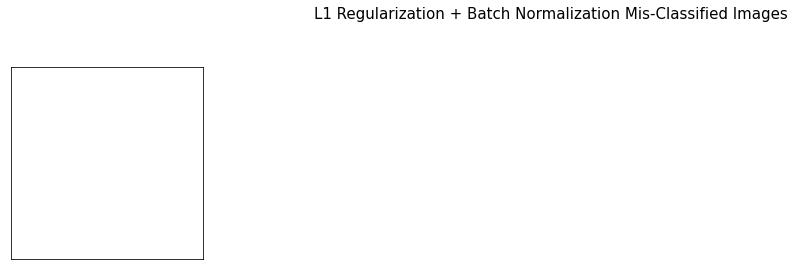

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
fig = plt.figure(figsize=(20, 8))
fig.suptitle("L1 Regularization + Batch Normalization Mis-Classified Images", fontsize=15)
for idx in range(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  img = np.squeeze(l1_bn_preds_raw[idx][idx])
  img_pred = l1_bn_preds_y_pred[idx].item()
  img_true = l1_bn_preds_y_true[idx][idx].item()
  plt.imshow(img.cpu().numpy())
  ax.set_title(f"Prediction : {img_pred} \n (label: {img_true})")

Text(0.5, 1.0, 'Test Accuracy')

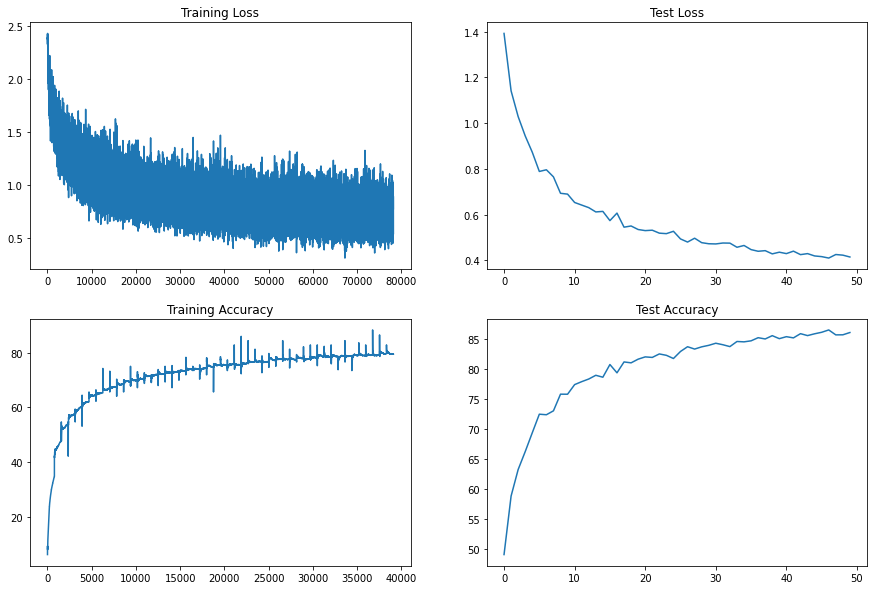

In [7]:

import numpy as np
t = [t.cpu().item() for t in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [8]:
print('Total Model Parameters : ', sum(p.numel() for p in model.parameters()))
print('Best Train Accuracy : ', max(train_acc))
print('Best Test Accuracy : ', max(test_acc))
x = [x for x in test_acc if x >= 85]
print('# of Epochs with test accuracy above 85% threshold:', len(x))

Total Model Parameters :  151902
Best Train Accuracy :  88.28125
Best Test Accuracy :  86.45
# of Epochs with test accuracy above 85% threshold: 13


In [ ]:
# from torch.optim.lr_scheduler import StepLR

# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
# EPOCHS = 50
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, trainloader, optimizer, epoch)
#     #scheduler.step()
#     test(model, device, testloader)

In [18]:
incorr_X[0].shape

torch.Size([64, 3, 32, 32])

<class 'torch.Tensor'>
cuda:0


TypeError: ignored

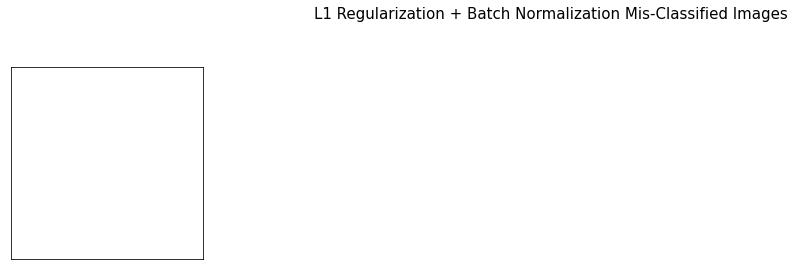

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
fig = plt.figure(figsize=(20, 8))
fig.suptitle("L1 Regularization + Batch Normalization Mis-Classified Images", fontsize=15)
for idx in range(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  img = np.squeeze(incorr_X[idx][idx])
  img_pred = incorr_argmax[idx].item()
  img_true = incorr_y[idx][idx].item()
  print(type(img))
  print(img.device)
  # print(img.cpu().numpy())
  plt.imshow(img.cpu().numpy())
  plt.imshow(img)
  ax.set_title(f"Prediction : {img_pred} \n (label: {img_true})")

In [ ]:
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        # The below code is added to identify misclassified images

        for idx, i in enumerate(output):
          if torch.argmax(i) == target[idx]:
            correct += 0 
            # To avoid double counting we don't add 1 here. If the above line of code ``` correct += pred.eq(target.view_as(pred)).sum().item() ```
            # wasn't there, we would add 1 here
          else:
            incorr_X.append(data)
            incorr_y.append(target)
            incorr_argmax.append(torch.argmax(i))

In [ ]:
with torch.no_grad():
  for data, target in testloader:
